# Alzheimer prediction based on numerical data 

## Summary

In this Notebook the numerical data which is provided for the ADNI1 dataset in the Tadpole challenge will be used to make predictions with the brain measurement values only. 

**NOTE**: In this notebook we will only predict healthy (= 0) and AD (=1), so it is a binary classification problem. 

### The datasets 

The ADNI-1 dataset contains 831 subjects, which have been classified into control, MCI and Alzheimer's.  



In [1]:
# Import all the required packages 

# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches
from numpy import isnan
import sys
sys.path.append('../')

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

np.random.seed(42)

# Load functions to get the dataset and process it 
from preprocessing.getdata import *

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_num import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

#### Modeling with the brain measurements only - binary prediction with ADNI dataset

In [16]:
# Load the preprocessed Adni dataset (from preprocessing/ADNI_numerical_processing)
df = pd.read_csv('../data/df_ADNI_modelling.csv')

In [17]:
dftrain = df[df["Train"] == True]
dftest = df[df["Train"] == False]
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train
0,77.0,53920.0,7244.0,1053590.0,4282.0,28.0,0.0,137_S_0973,M,1,True
1,72.0,39452.0,8187.6,1152890.0,4139.2,25.0,1.0,036_S_0945,M,1,True


In [18]:
#Drop the columns with the imputed and train labels 
df.drop(columns=['Imputed', 'ID', "MMSE"], inplace=True, axis=1)

In [19]:
#Create a dummy column for the sex 
df = pd.get_dummies(df)

In [20]:
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,Train,Sex_F,Sex_M
0,77.0,53920.0,7244.0,1053590.0,4282.0,1,True,0,1
1,72.0,39452.0,8187.6,1152890.0,4139.2,1,True,0,1


In [21]:
#Perform train test split 
X=df.drop('label', axis=1)
y_train=dftrain['label']
y_test=dftest['label']

X_train = X[X["Train"] == True]
X_test = X[X["Train"] == False]

In [22]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 

scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [23]:
X_train_scaled.shape

(297, 8)

In [24]:
X_train

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Train,Sex_F,Sex_M
0,77.0,53920.0,7244.0,1053590.0,4282.0,True,0,1
1,72.0,39452.0,8187.6,1152890.0,4139.2,True,0,1
2,66.0,26273.0,6264.0,916950.0,3180.0,True,0,1
3,82.0,66806.0,5479.0,797415.0,3200.0,True,0,1
4,81.0,84599.0,5319.0,1129830.0,1791.0,True,0,1
...,...,...,...,...,...,...,...,...
292,77.0,72975.0,8609.0,1180660.0,3342.0,True,0,1
293,81.0,33863.0,6402.6,963964.0,2759.6,True,1,0
294,74.0,36501.0,7723.0,1112400.0,3442.0,True,0,1
295,85.0,18757.0,6080.0,948684.0,4190.0,True,1,0


In [25]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['Age', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Train', 'Sex_F', 'Sex_M'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Age', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Train', 'Sex_F', 'Sex_M'])
X_test_scaled.drop("Train", inplace=True, axis=1)
X_train_scaled.drop("Train", inplace=True, axis=1)

In [27]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(100,200,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='balanced_accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.500 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.500 total time=   0.1s
[CV 2

/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/User

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 175}

In [28]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [29]:
y_pred_tuned.shape  

(99,)

In [30]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 1.0
The accuracy on the test dataset is 0.6767676767676768


In [31]:
probabilites_2 = best_model.predict_proba(X_test_scaled)

In [32]:
probabilites_2.shape

(99, 2)

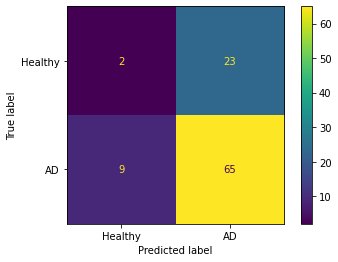

In [33]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [34]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.18      0.08      0.11        25
           1       0.74      0.88      0.80        74

    accuracy                           0.68        99
   macro avg       0.46      0.48      0.46        99
weighted avg       0.60      0.68      0.63        99



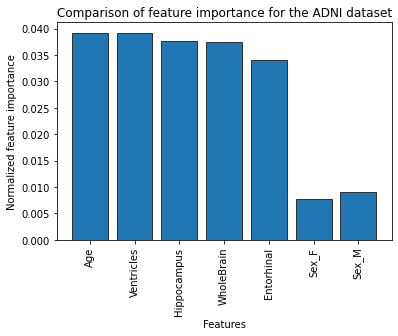

In [35]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X_test_scaled.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

In [36]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.6767676767676768, 'train-accuracy': 1.0}, params={}, tags={'mlflow.runName': '1_oasis_trans_scaled_SVM',
 'mlflow.source.git.commit': '0054da52d0f1cb0466b91f538867e1511dfc471f',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/c864a1ad514c4e6e8fc2ef29fe0cdb96/artifacts', end_time=1662964687164, experiment_id='56', lifecycle_stage='active', run_id='c864a1ad514c4e6e8fc2ef29fe0cdb96', run_uuid='c864a1ad514c4e6e8fc2ef29fe0cdb96', start_time=1662963780660, status='FINISHED', user_id='tamarapallien'>>

#### 4. Error Analysis for the ADNI dataset

For the error analysis we will add the y_pred to our X_test dataframe.  

In [37]:
#Convert X_test into a dataframe 
df_ea = pd.DataFrame(dftest)
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train
297,86.0,53980.0,6326.2,946436.0,3577.4,27.0,1.0,029_S_1218,F,1,False
298,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False
299,74.0,16676.0,7513.0,858650.0,3469.0,29.0,0.0,094_S_0489,F,0,False
300,82.0,29415.0,6637.0,790001.0,2817.0,30.0,0.0,016_S_0359,F,0,False
301,75.0,14658.0,7665.0,1021180.0,4248.0,29.0,0.0,031_S_0618,M,0,False
...,...,...,...,...,...,...,...,...,...,...,...
391,77.0,62890.0,4951.0,828140.0,2275.0,25.0,0.0,012_S_0712,M,1,False
392,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,1,False
393,74.0,93791.0,8523.0,1277240.0,4084.0,27.0,0.0,126_S_0865,M,0,False
394,78.0,23532.0,5067.0,1021830.0,2770.0,28.0,0.0,036_S_0673,M,1,False


In [38]:
#Add the test values and the predicted values to the dataframe 
df_ea['y_test_num'] = y_test.values
df_ea['y_pred_num'] = y_pred_tuned
df_ea["probs1_num"] = probabilites_2[:,1]
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train,y_test_num,y_pred_num,probs1_num
297,86.0,53980.0,6326.2,946436.0,3577.4,27.0,1.0,029_S_1218,F,1,False,1,1,0.931429
298,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False,1,1,0.643571
299,74.0,16676.0,7513.0,858650.0,3469.0,29.0,0.0,094_S_0489,F,0,False,0,1,0.788571
300,82.0,29415.0,6637.0,790001.0,2817.0,30.0,0.0,016_S_0359,F,0,False,0,1,0.765714
301,75.0,14658.0,7665.0,1021180.0,4248.0,29.0,0.0,031_S_0618,M,0,False,0,0,0.413061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,77.0,62890.0,4951.0,828140.0,2275.0,25.0,0.0,012_S_0712,M,1,False,1,1,0.845714
392,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,1,False,1,1,0.805714
393,74.0,93791.0,8523.0,1277240.0,4084.0,27.0,0.0,126_S_0865,M,0,False,0,1,0.954286
394,78.0,23532.0,5067.0,1021830.0,2770.0,28.0,0.0,036_S_0673,M,1,False,1,1,0.544524


In [39]:
# We write a function to add the classification (TP, TN, FP and FN) to our dataframe 
def classification(row): 
    if (row.y_test_num == 1) & (row.y_pred_num == 1): 
        return 'TP'
    if (row.y_test_num ==1 ) & (row.y_pred_num == 0): 
        return 'FN'
    if (row.y_test_num == 0) & (row.y_pred_num == 1):
        return 'FP'
    if (row.y_test_num == 0) & (row.y_pred_num == 0): 
        return 'TN'
 

df_ea['classification']=df_ea.apply(lambda row: classification (row), axis=1)

In [40]:
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train,y_test_num,y_pred_num,probs1_num,classification
297,86.0,53980.0,6326.2,946436.0,3577.4,27.0,1.0,029_S_1218,F,1,False,1,1,0.931429,TP
298,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False,1,1,0.643571,TP
299,74.0,16676.0,7513.0,858650.0,3469.0,29.0,0.0,094_S_0489,F,0,False,0,1,0.788571,FP
300,82.0,29415.0,6637.0,790001.0,2817.0,30.0,0.0,016_S_0359,F,0,False,0,1,0.765714,FP
301,75.0,14658.0,7665.0,1021180.0,4248.0,29.0,0.0,031_S_0618,M,0,False,0,0,0.413061,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,77.0,62890.0,4951.0,828140.0,2275.0,25.0,0.0,012_S_0712,M,1,False,1,1,0.845714,TP
392,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,1,False,1,1,0.805714,TP
393,74.0,93791.0,8523.0,1277240.0,4084.0,27.0,0.0,126_S_0865,M,0,False,0,1,0.954286,FP
394,78.0,23532.0,5067.0,1021830.0,2770.0,28.0,0.0,036_S_0673,M,1,False,1,1,0.544524,TP


In [41]:
#Save the predictions as a dataframe 
df_ea.to_csv("../modelling/num_predictions.csv", index=False)

In [42]:
df_ea['classification'].nunique()

4

In [43]:
# We can have a look on our Top 10 wrongly classified entries 
df_ea_fp = df_ea.query('classification == "FP"').head(10)
print(f'An example of 10 false positive (FP) entries are the following: {df_ea_fp}')

An example of 10 false positive (FP) entries are the following:       Age  Ventricles  Hippocampus  WholeBrain  Entorhinal  MMSE  Imputed  \
299  74.0     16676.0       7513.0    858650.0      3469.0  29.0      0.0   
300  82.0     29415.0       6637.0    790001.0      2817.0  30.0      0.0   
305  73.0     29040.0       6881.8   1000980.0      3072.0  28.0      1.0   
312  83.0     49716.0       7164.0   1038970.0      3903.0  30.0      0.0   
317  73.0     19672.0       7730.2   1231190.0      3778.2  30.0      1.0   
320  66.0     17315.0       7309.0    936539.0      3470.0  28.0      0.0   
323  79.0     19606.0       7064.0   1112520.0      3516.0  28.0      0.0   
324  74.0     60763.0       8005.0   1039760.0      3022.0  27.0      0.0   
326  79.0     75080.0       6125.0   1004690.0      3124.0  26.0      0.0   
336  79.0     25179.0       5934.0    884947.0      2956.6  29.0      1.0   

             ID Sex  label  Train  y_test_num  y_pred_num  probs1_num  \
299  094_S_0489

In [44]:
df_ea_fp.Age.mean()

76.2

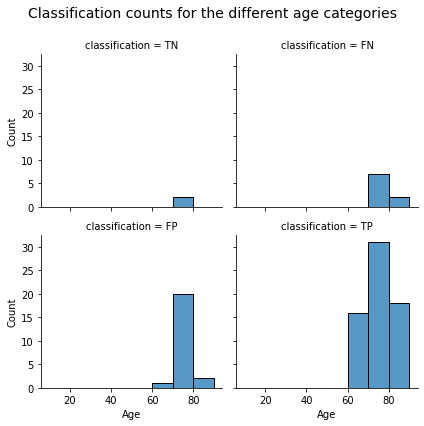

In [45]:
#Plot the classification for the Age 

plot=sns.FacetGrid(data=df_ea, col='classification', col_wrap=2, col_order=['TN', 'FN', 'FP', 'TP'])
plot.map_dataframe(sns.histplot, x='Age', binrange=(10,90), binwidth=10)
plot.fig.subplots_adjust(top=0.87)
plot.fig.suptitle('Classification counts for the different age categories', fontsize=14);

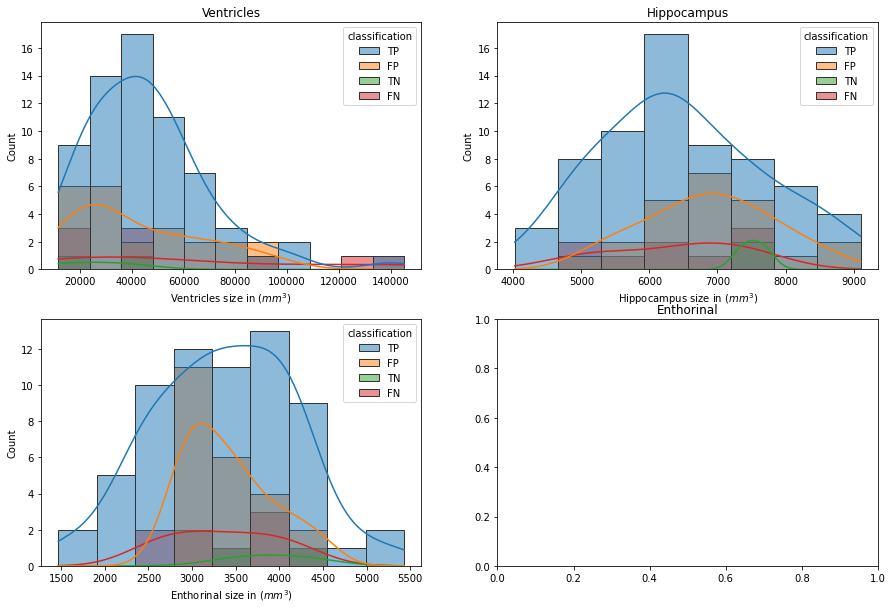

In [46]:
#Plot the classification for the Ventricles, Hippocampus,WholeBrain and	Enthorinal	 

#Create plots with all three different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Ventricles
sns.histplot(ax=axes[0,0],data=df_ea, x='Ventricles', edgecolor=".2", hue='classification', kde=True).set(xlabel='Ventricles size in ($mm^3$)', ylabel='Count')
axes[0,0].set_title('Ventricles');

#Hippocampus
sns.histplot(ax=axes[0,1],data=df_ea, x='Hippocampus', edgecolor=".2", hue='classification', kde=True).set(xlabel='Hippocampus size in ($mm^3$)', ylabel='Count')
axes[0,1].set_title('Hippocampus');


#Entorhinal
sns.histplot(ax=axes[1,0],data=df_ea, x='Entorhinal', edgecolor=".2", hue='classification', kde=True).set(xlabel='Enthorinal size in ($mm^3$)', ylabel='Count')
axes[1,1].set_title('Enthorinal');